In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize
from scipy.interpolate import interp2d
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from labellines import labelLines
from labellines import labelLine
from PIL import Image

<ipython-input-6-d16ef8f3301f>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['detected'] = data['detected'].rolling(window=4).mean()
<ipython-input-6-d16ef8f3301f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['error'] = data['error'].rolling(window=4).mean()


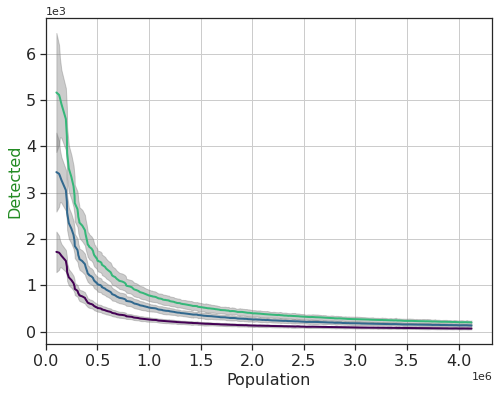

In [6]:
sns.set_theme(style="ticks")

fig,ax = plt.subplots(figsize=(8,6))

label_size = 16
abc_size = 16*1.6

name = 'ma'
betastr = '3,0'
heatmap = pd.read_csv('tests/out/' + name + '_30k_beta_' + betastr +
                        '.txt', sep='\t')

colormap = mpl.colormaps['viridis']

for i,ntests in enumerate([10000, 20000, 30000]):
    data = heatmap[heatmap['tests'] == ntests]
    #rolling average of data
    data['detected'] = data['detected'].rolling(window=4).mean()
    data['error'] = data['error'].rolling(window=4).mean()
    color = colormap(i/3)
    ax.plot('population', 'detected', data=data, color=color, lw=2)
    ax.fill_between(x=data['population'], y1=data['detected']+ 1*data['error'], y2=data['detected']-1*data['error'], color='gray', alpha=0.4)

ax.set_xlabel('Population', size=label_size)
ax.set_ylabel('Detected', size=label_size, color='forestgreen')
ax.tick_params(labelsize=label_size)
ax.set_xlim(0,)
ax.grid('True')
ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0))

fig.savefig('figures/figs_dec23/Fig3a.svg', bbox_inches='tight', dpi=300)

In [11]:
data

,population,links,tests,detected,time,error,time_error
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,5729.79250,NaN,119.753975,NaN
4,NaN,NaN,NaN,5564.97000,NaN,121.172225,NaN
...,...,...,...,...,...,...,...
252,NaN,NaN,NaN,438.84375,NaN,52.594475,NaN
253,NaN,NaN,NaN,438.17700,NaN,52.903775,NaN
254,NaN,NaN,NaN,437.82275,NaN,46.375175,NaN
255,NaN,NaN,NaN,437.49975,NaN,44.792050,NaN


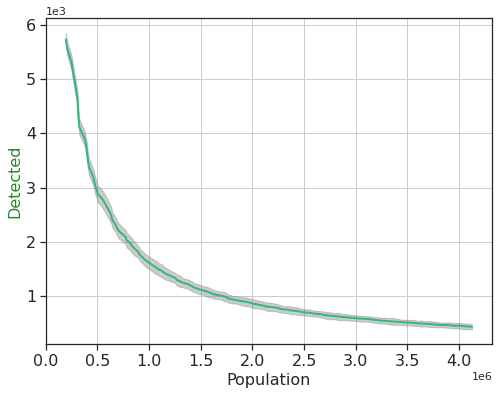

In [13]:
sns.set_theme(style="ticks")

fig,ax = plt.subplots(figsize=(8,6))

label_size = 16
abc_size = 16*1.6

name = 'ma'
betastr = '4,0'
for i in enumerate([1,2,3]):
heatmap = pd.read_csv('times/out/' + name + '_{i}k_60d_beta_' + betastr +
                        '.txt', sep='\t')
heatmap['detected'] = heatmap['detected'].rolling(window=4).mean()
heatmap['error'] = heatmap['error'].rolling(window=4).mean()

colormap = mpl.colormaps['viridis']

#rolling average of data
color = colormap(i/3)
ax.plot('population', 'detected', data=heatmap, color=color, lw=2)
ax.fill_between(x=heatmap['population'], y1=heatmap['detected']+ 1*heatmap['error'], y2=heatmap['detected']-1*heatmap['error'], color='gray', alpha=0.4)

ax.set_xlabel('Population', size=label_size)
ax.set_ylabel('Detected', size=label_size, color='forestgreen')
ax.tick_params(labelsize=label_size)
ax.set_xlim(0,)
ax.grid('True')
ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0))

fig.savefig('figures/figs_dec23/Fig3b.svg', bbox_inches='tight', dpi=300)